# EDA

## I. Baseline

In [1]:
# Base.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Models.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# Metrics.
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
# Utilities.
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

np.random.seed(42)

In [2]:
try:
  df = pd.read_csv('train.csv')
except FileNotFoundError:
  df = pd.read_csv('https://drive.google.com/uc?export=download&id=1rAMWZuRhHYWSTnj1vzN7psOd6NXjqaRo')


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.shape

(891, 12)

In [5]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [6]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Описание признаков

Pclass [*Ординальный*] - Класс билета (1ый - лучший)<br>
Sex [*Бинарный*] - Пол пассажира<br>
Age [*Непрерывный*] - Возраст пассажира<br>
SibSp [*Дискретный*] - Количество братьев/сестёр/супругов на борту<br>
Parch [*Дискретный*] - Количество родителей/детей на борту<br>
Ticket [*Категориальный*] - Номер билета<br>
Fare [*Непрерывный*] - Стоимость билета<br>
Cabin [*Категориальный*] - Номер каюты<br>
Embarked [*Номинальный*] - Порт с которого пассажир попал на борт<br>
***
Целевой признак:<br>
Survived [*Бинарный*] - Выжил пассажир или нет

Проверяем данные на наличие нулевых значений. Замечаем, что признак "Cabin" на 77% состоит из пустых значений. Небольшая часть значений признаков "Age" и "Embarked" содержит нули.

In [7]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# сразу удалим колонку 'Cabin'
bl_df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

Проверяем есть ли в данных повторяющиеся объекты. В результате выполнения кода видим, что дубликатов нет.

In [9]:
df.duplicated().any()

False

### Подготовка данных

Заполняем пустые значения признака "Age" медианным значением, а признака "Embarked" - модой.

In [10]:
bl_df.Age = df.Age.fillna(df.Age.median())
bl_df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])

Кодируем признаки "Embarked" и "Sex".

In [11]:
bl_df = pd.get_dummies(
        bl_df,
        columns=['Embarked'],
        drop_first=True,
)
bl_df.Sex = df.Sex.replace({'female': 1, 'male': 0})

### Построение моделей

In [12]:
X = bl_df.drop('Survived', axis=1).values
y = bl_df.Survived.values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

Расчёт точностей моделей kNN с разным количеством k.

In [13]:
scores = {
  'Model' : [],
  'ROC AUC' : [],
  'Accuracy' : [],
  'Precision' : [],
  'Recall' : []
}

for n in [5, 15, 20, 25, 30]:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)

  preds_valid = knn.predict(X_valid)

  scores['Model'].append(f'{n}-neighbors kNN')
  scores['ROC AUC'].append(roc_auc_score(y_valid, preds_valid))
  scores['Accuracy'].append(accuracy_score(y_valid, preds_valid))
  scores['Precision'].append(precision_score(y_valid, preds_valid))
  scores['Recall'].append(recall_score(y_valid, preds_valid))


Расчёт точности модели логарифмической регрессии.

In [14]:
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)

preds_valid = log_regression.predict(X_valid)

scores['Model'].append('Logistic Regression')
scores['ROC AUC'].append(roc_auc_score(y_valid, preds_valid))
scores['Accuracy'].append(accuracy_score(y_valid, preds_valid))
scores['Precision'].append(precision_score(y_valid, preds_valid))
scores['Recall'].append(recall_score(y_valid, preds_valid))

In [15]:
pd.DataFrame(data=scores)

,Model,ROC AUC,Accuracy,Precision,Recall
0,5-neighbors kNN,0.671042,0.698324,0.678571,0.513514
1,15-neighbors kNN,0.708366,0.737430,0.754717,0.540541
2,20-neighbors kNN,0.680116,0.720670,0.785714,0.445946
3,25-neighbors kNN,0.694402,0.737430,0.846154,0.445946
4,30-neighbors kNN,0.646332,0.692737,0.756757,0.378378
5,Logistic Regression,0.800193,0.810056,0.785714,0.743243


## II. Mainline

### Analysis

Проверка корреляции между признаками.

<Axes: >

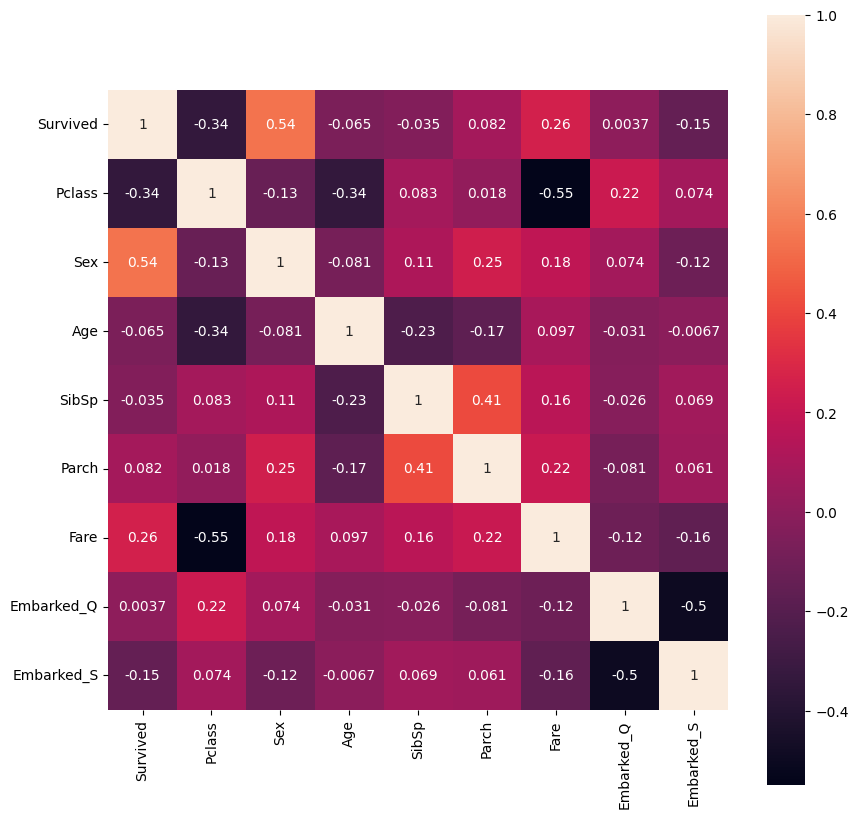

In [16]:
plt.subplots(figsize=(10, 10))
sns.heatmap(bl_df.corr(), square=True, annot=True)

In [17]:
df.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [18]:
df.SibSp.value_counts()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [19]:
df.Parch.value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [20]:
df_pr = df.copy()

Извлекаем из признака "Name" два новых признака "Title" и "Surname"

In [21]:
df_pr['Title'] = df_pr.Name.apply(lambda x : x.replace(',', '').split()[1])
df_pr['Surname'] = df_pr.Name.apply(lambda x : x.replace(',', '').split()[0])

Заполняем пустые значения признака "Age" медианными значениями по каждому из 4 самых распространенных титулов. 

In [22]:
median_ages = {
    'Mr.' : df_pr.loc[df_pr.Title == 'Mr.'].Age.median(),
    'Miss.' : df_pr.loc[df_pr.Title == 'Miss.'].Age.median(),
    'Mrs.' : df_pr.loc[df_pr.Title == 'Mrs.'].Age.median(),
    'Master.' : df_pr.loc[df_pr.Title == 'Master.'].Age.median()
}

In [23]:
for title, median in median_ages.items():
  cond1 = df_pr['Age'].isna()
  cond2 = df_pr['Title'] == title
  df_pr.loc[cond1 & cond2, 'Age'] = median

In [24]:
df_pr.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              3
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
Surname          0
dtype: int64

Замечаем что после такого метода заполнения в признаке "Age" остается только 3 пустых значения. Видим что выбранные 3 объекта имеют общее значение признака "Sex", поэтому заполняем значение "Age" медианным значением по объектам с таким же значением "Sex".

In [25]:
df_pr.loc[df_pr.Age.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
547,548,1,2,"Padro y Manent, Mr. Julian",male,NaN,0,0,SC/PARIS 2146,13.8625,NaN,C,y,Padro
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,Dr.,Brewe
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,Melkebeke,van


In [26]:
df_pr.Age.fillna(df_pr.loc[df_pr.Sex == 'male'].Age.median(), inplace=True)

In [27]:
# df_pr.groupby(['Surname']).sum().SibSp.apply(lambda x : x > 1)
df_pr.loc[(df_pr.SibSp > 1) & (df_pr.Survived == 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.00,4,2,3101281,7.9250,NaN,S,Miss.,Andersson
85,86,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.00,3,0,3101278,15.8500,NaN,S,Mrs.,Backstrom
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S,Miss.,Fortune
183,184,1,2,"Becker, Master. Richard F",male,1.00,2,1,230136,39.0000,F4,S,Master.,Becker
233,234,1,3,"Asplund, Miss. Lillian Gertrud",female,5.00,4,2,347077,31.3875,NaN,S,Miss.,Asplund
261,262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.00,4,2,347077,31.3875,NaN,S,Master.,Asplund
301,302,1,3,"McCoy, Mr. Bernard",male,30.00,2,0,367226,23.2500,NaN,Q,Mr.,McCoy
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,Miss.,Ryerson
330,331,1,3,"McCoy, Miss. Agnes",female,21.00,2,0,367226,23.2500,NaN,Q,Miss.,McCoy
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.00,3,2,19950,263.0000,C23 C25 C27,S,Miss.,Fortune


In [28]:
df_pr.loc[(df_pr.SibSp > 1) & (df_pr.Survived == 1)].shape[0] / df_pr.shape[0]

0.02244668911335578

In [29]:
df_pr = pd.get_dummies(df_pr, columns=['Pclass', 'Embarked'], drop_first=True)
df_pr = df_pr.drop(columns=['Ticket', 'Title', 'Surname', 'Name', 'PassengerId', 'Cabin'])

In [30]:
df_pr.Sex = df_pr.Sex.replace({'female': 1, 'male': 0})

In [31]:
df_pr.isna().sum()

Survived      0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Pclass_2      0
Pclass_3      0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [32]:
X = df_pr.drop(columns='Survived').values
y = df_pr.Survived.values

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X_sc, y, test_size=0.2)

for n in [3, 5, 7]:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  preds_valid = knn.predict(X_valid)
  print('При количестве соседей: {}'.format(n))
  print(f'Accuracy  = {accuracy_score(y_valid, preds_valid)}')
  print(f'Precision = {precision_score(y_valid, preds_valid)}')
  print(f'Recall    = {recall_score(y_valid, preds_valid)}')
  print(f'ROC AUC   = {roc_auc_score(y_valid, preds_valid)}\n')

При количестве соседей: 3
Accuracy  = 0.7877094972067039
Precision = 0.7352941176470589
Recall    = 0.7142857142857143
ROC AUC   = 0.7745740498034076

При количестве соседей: 5
Accuracy  = 0.7988826815642458
Precision = 0.7833333333333333
Recall    = 0.6714285714285714
ROC AUC   = 0.7760812581913499

При количестве соседей: 7
Accuracy  = 0.7877094972067039
Precision = 0.7580645161290323
Recall    = 0.6714285714285714
ROC AUC   = 0.7669069462647442



In [34]:
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)
preds_train = log_regression.predict(X_train)
preds_valid = log_regression.predict(X_valid)
print(f'Train score : {roc_auc_score(y_train, preds_train)}')
print(f'Test score  : {roc_auc_score(y_valid, preds_valid)}')

Train score : 0.7837901069518717
Test score  : 0.7766055045871559


In [35]:
df_pr

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,0,22.0,1,0,7.2500,False,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False,False
2,1,1,26.0,0,0,7.9250,False,True,False,True
3,1,1,35.0,1,0,53.1000,False,False,False,True
4,0,0,35.0,0,0,8.0500,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,13.0000,True,False,False,True
887,1,1,19.0,0,0,30.0000,False,False,False,True
888,0,1,21.0,1,2,23.4500,False,True,False,True
889,1,0,26.0,0,0,30.0000,False,False,False,False


In [36]:
import catboost as cb
CB_model = cb.CatBoostClassifier(verbose=0)
CB_model.fit(X_train, y_train)

ModuleNotFoundError: No module named 'catboost'

TEST
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       109
           1       0.81      0.73      0.77        70

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179

TRAIN
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       440
           1       0.93      0.83      0.88       272

    accuracy                           0.91       712
   macro avg       0.92      0.90      0.91       712
weighted avg       0.91      0.91      0.91       712



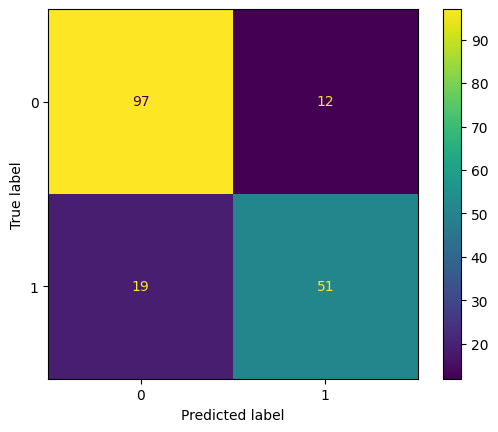

In [ ]:
# Получить отчет классификации передав в classification_report реальные метки и предсказанные
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print("TEST")
print(classification_report(y_valid, CB_model.predict(X_valid)))
print("TRAIN")
print(classification_report(y_train, CB_model.predict(X_train)))

# Посмотреть на матрицу ошибок, передав в plot_confusion_matrix модель, тестовые данные и тестовые метки
ConfusionMatrixDisplay.from_estimator(CB_model, X_valid, y_valid)
plt.grid(False)
plt.show()

TEST
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       109
           1       0.79      0.71      0.75        70

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       440
           1       0.99      0.97      0.98       272

    accuracy                           0.98       712
   macro avg       0.98      0.98      0.98       712
weighted avg       0.98      0.98      0.98       712



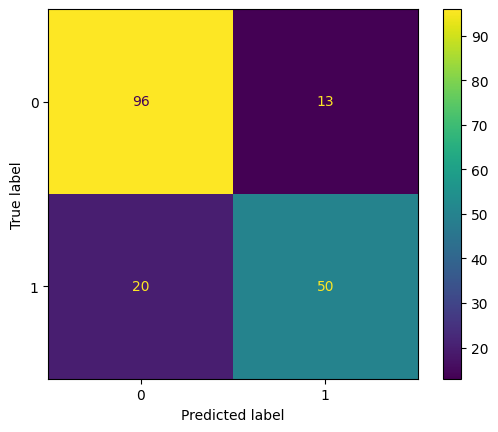

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier().fit(X_train, y_train)


print("TEST")
print(classification_report(y_valid, forest.predict(X_valid)))
print("TRAIN")
print(classification_report(y_train, forest.predict(X_train)))

# Посмотреть на матрицу ошибок, передав в plot_confusion_matrix модель, тестовые данные и тестовые метки
ConfusionMatrixDisplay.from_estimator(forest, X_valid, y_valid)
plt.grid(False)
plt.show()